In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Image

def display_images(image_path1, image_path2):
        # read images
        img_A = mpimg.imread(image_path1)
        img_B = mpimg.imread(image_path2)

        # pad top with white space
        larger = max(img_A.shape[0], img_B.shape[0])
        img_A = np.pad(img_A, ((larger - img_A.shape[0], 0), (0, 0), (0, 0)), mode='constant', constant_values=1)
        img_B = np.pad(img_B, ((larger - img_B.shape[0], 0), (0, 0), (0, 0)), mode='constant', constant_values=1)

        # stack
        img = np.concatenate((img_A, img_B), axis=1)
        # save tmp image
        tmp_path = 'tmp.png'
        plt.imsave(tmp_path, img)
        return Image(tmp_path, width=600)

In [3]:
#chr1:10,192,757-11,165,236
chrom = 'chr1'
start = 10000000
region = 'chr1:10192757-11165236'

First we compare to the experimental data.

In [4]:
! python ../src/cshark/inference/perturb.py \
    --celltype 129_b6_5kb \
    --outname baseline \
    --chr $chrom \
    --start $start \
    --model /mnt/jinstore/JinLab02/dmp131/C.Shark/checkpoints/deeploop_b6_129_CTCF_ATAC_5kb.ckpt \
    --seq ../cshark_data/data/mm10/dna_sequence \
    --seq2 ../cshark_data/data/129/dna_sequence \
    --matrix-size 512 \
    --resolution 4096 \
    --region $region \
    --min-val-pred 0.01 \
    --bigwigs ctcf=../cshark_data/data/mm10/129_b6_5kb/genomic_features/ctcf.bw \
              atac=../cshark_data/data/mm10/129_b6_5kb/genomic_features/atac.bw \
    --silent

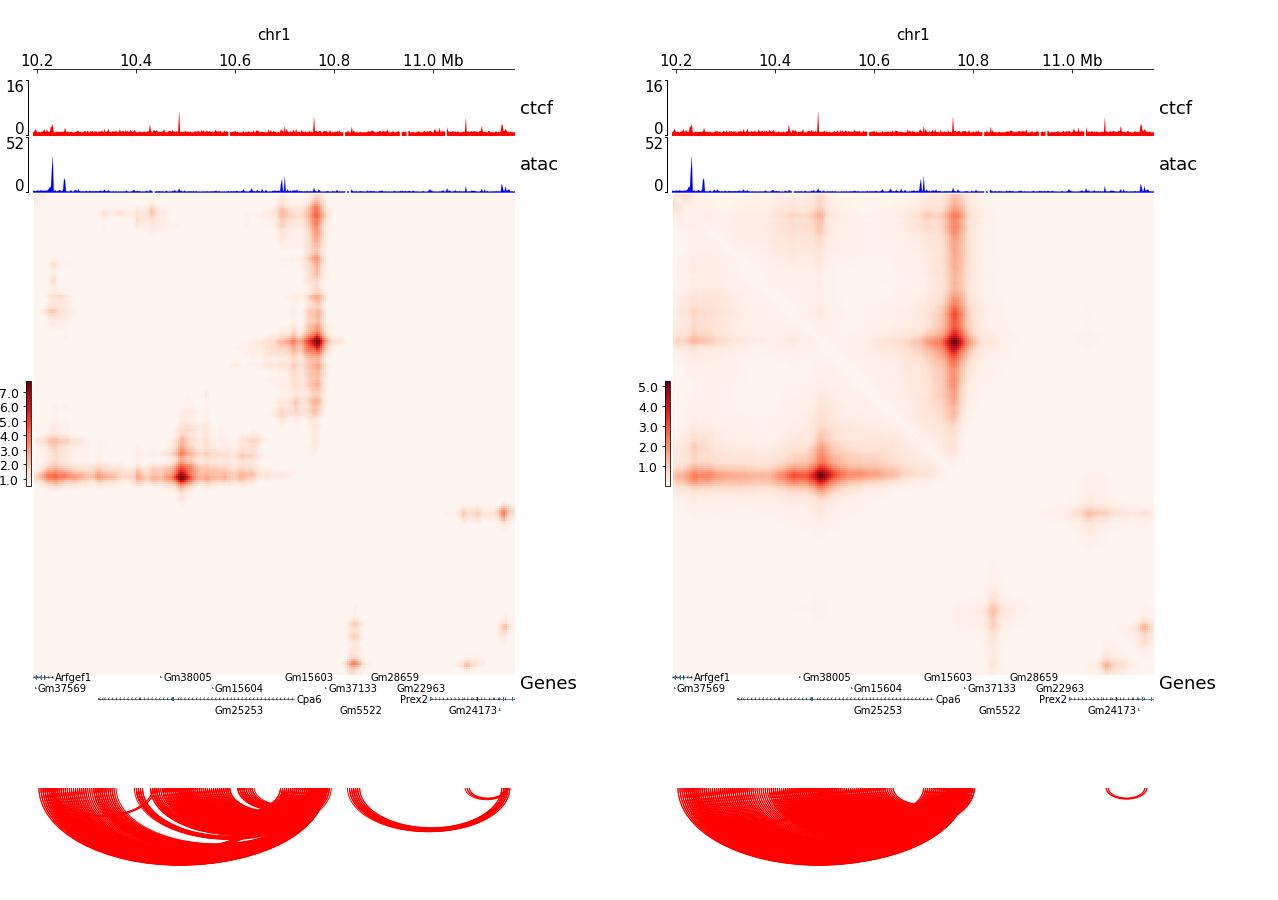

In [5]:
display_images(f'outputs/baseline_129_b6_5kb_{chrom}_{start}_ctcf_true_tracks.png', 
               f'outputs/baseline_129_b6_5kb_{chrom}_{start}_ctcf_pred_tracks.png')

Next, we will run prediction but replacing the separate alleles with the sequence from only one strain to see if we can predict allele-specific differences.

In [6]:
! python ../src/cshark/inference/perturb.py \
    --celltype 129_b6_5kb \
    --outname b6 \
    --chr $chrom \
    --start $start \
    --model /mnt/jinstore/JinLab02/dmp131/C.Shark/checkpoints/deeploop_b6_129_CTCF_ATAC_5kb.ckpt \
    --seq ../cshark_data/data/mm10/dna_sequence \
    --seq2 ../cshark_data/data/mm10/dna_sequence \
    --matrix-size 512 \
    --resolution 4096 \
    --region $region \
    --min-val-pred 0.01 \
    --bigwigs ctcf=../cshark_data/data/mm10/129_b6_5kb/genomic_features/ctcf.bw \
              atac=../cshark_data/data/mm10/129_b6_5kb/genomic_features/atac.bw \
    --silent

In [7]:
import cooler 

b6_cool = cooler.Cooler('tmp/tmp.cool')
b6_mat = b6_cool.matrix(balance=False).fetch(region)

In [8]:
! python ../src/cshark/inference/perturb.py \
    --celltype 129_b6_5kb \
    --outname 129 \
    --chr $chrom \
    --start $start \
    --model /mnt/jinstore/JinLab02/dmp131/C.Shark/checkpoints/deeploop_b6_129_CTCF_ATAC_5kb.ckpt \
    --seq ../cshark_data/data/129/dna_sequence \
    --seq2 ../cshark_data/data/129/dna_sequence \
    --matrix-size 512 \
    --resolution 4096 \
    --region $region \
    --min-val-pred 0.01 \
    --bigwigs ctcf=../cshark_data/data/mm10/129_b6_5kb/genomic_features/ctcf.bw \
              atac=../cshark_data/data/mm10/129_b6_5kb/genomic_features/atac.bw \
    --silent

In [9]:
mm10_cool = cooler.Cooler('tmp/tmp.cool')
mm10_mat = mm10_cool.matrix(balance=False).fetch(region)

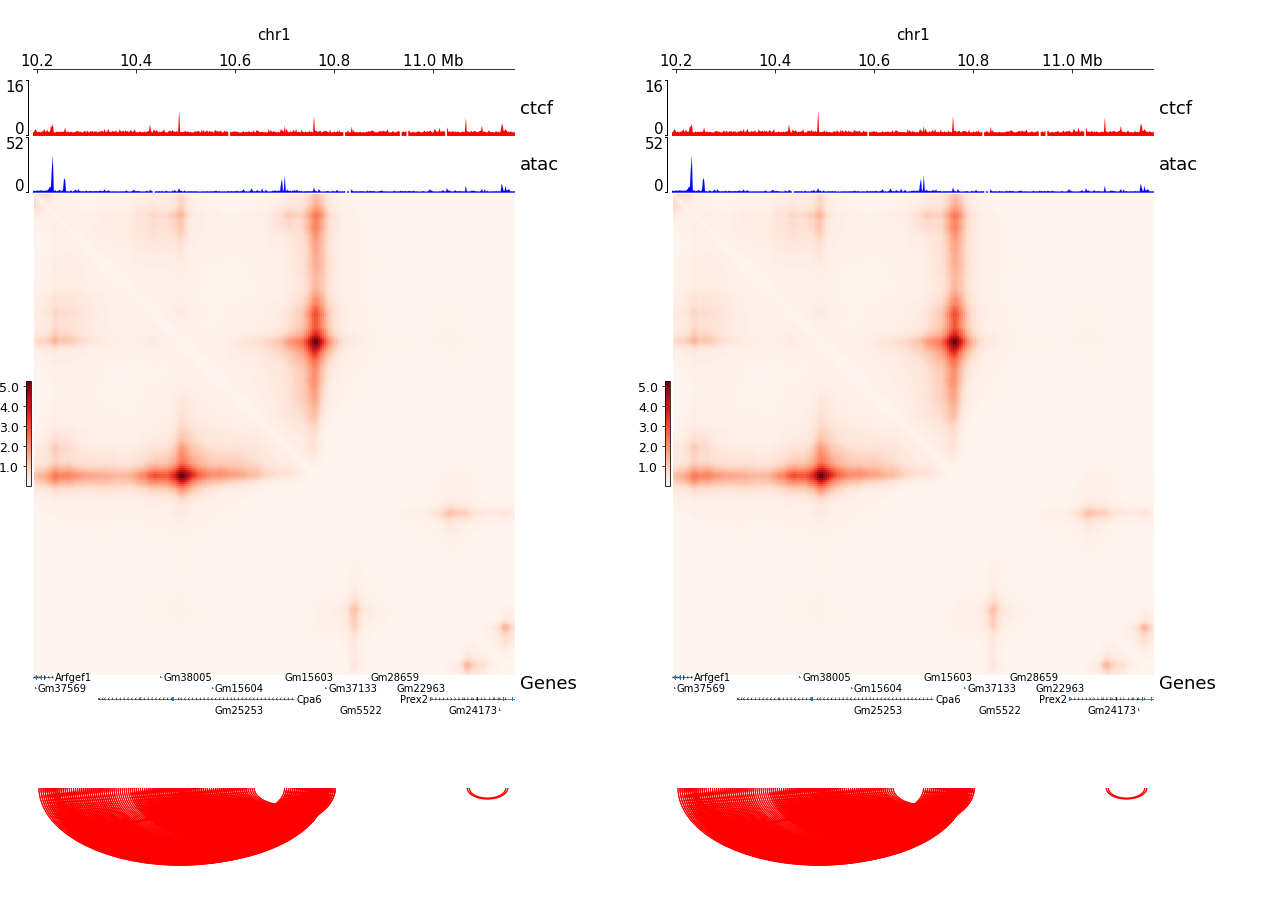

In [10]:
display_images(f'outputs/b6_129_b6_5kb_{chrom}_{start}_ctcf_pred_tracks.png', 
               f'outputs/129_129_b6_5kb_{chrom}_{start}_ctcf_pred_tracks.png')

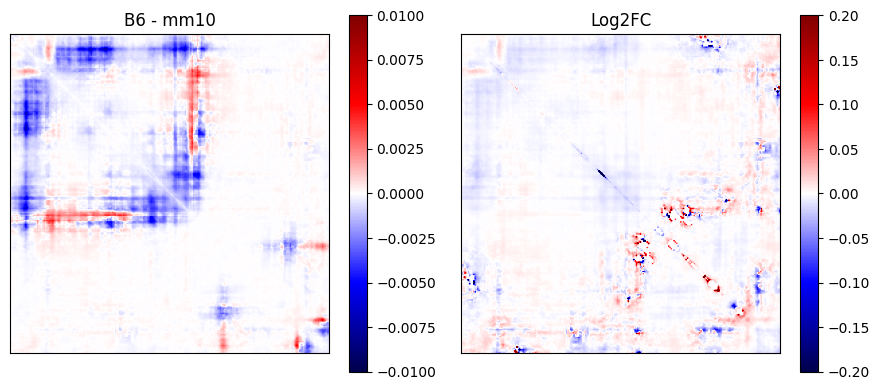

In [18]:
diff = b6_mat - mm10_mat
EPS = 1e-5
log2fc = np.log2((np.clip(b6_mat, 0, None) + EPS) / (np.clip(mm10_mat, 0, None) + EPS))

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
# plt.imshow(log2fc, cmap='bwr', vmin=-0.5, vmax=0.5)
im = axs[0].imshow(diff, cmap='seismic', vmin=-0.01, vmax=0.01)
plt.colorbar(im, ax=axs[0])
axs[0].set_title('B6 - mm10')
axs[0].set_xticks([])
axs[0].set_yticks([])
im = axs[1].imshow(log2fc, cmap='seismic', vmin=-0.2, vmax=0.2)
plt.colorbar(im, ax=axs[1])
axs[1].set_title('Log2FC')
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.tight_layout()
plt.show()

Then, we can perturb the CTCF sites at these loops to see which sites might be mediating these interactions.

In [12]:
! python ../src/cshark/inference/perturb.py \
    --celltype 129_b6_5kb \
    --outname ctcf_ko_only \
    --chr $chrom \
    --start $start \
    --model /mnt/jinstore/JinLab02/dmp131/C.Shark/checkpoints/deeploop_b6_129_CTCF_ATAC_5kb.ckpt \
    --seq ../cshark_data/data/mm10/dna_sequence \
    --seq2 ../cshark_data/data/129/dna_sequence \
    --matrix-size 512 \
    --resolution 4096 \
    --region $region \
    --ko-start 10480000 \
    --ko-width 20000 \
    --ko ctcf \
    --ko-mode knockout \
    --min-val-pred 0.5 \
    --bigwigs ctcf=../cshark_data/data/mm10/129_b6_5kb/genomic_features/ctcf.bw \
              atac=../cshark_data/data/mm10/129_b6_5kb/genomic_features/atac.bw \
    --silent

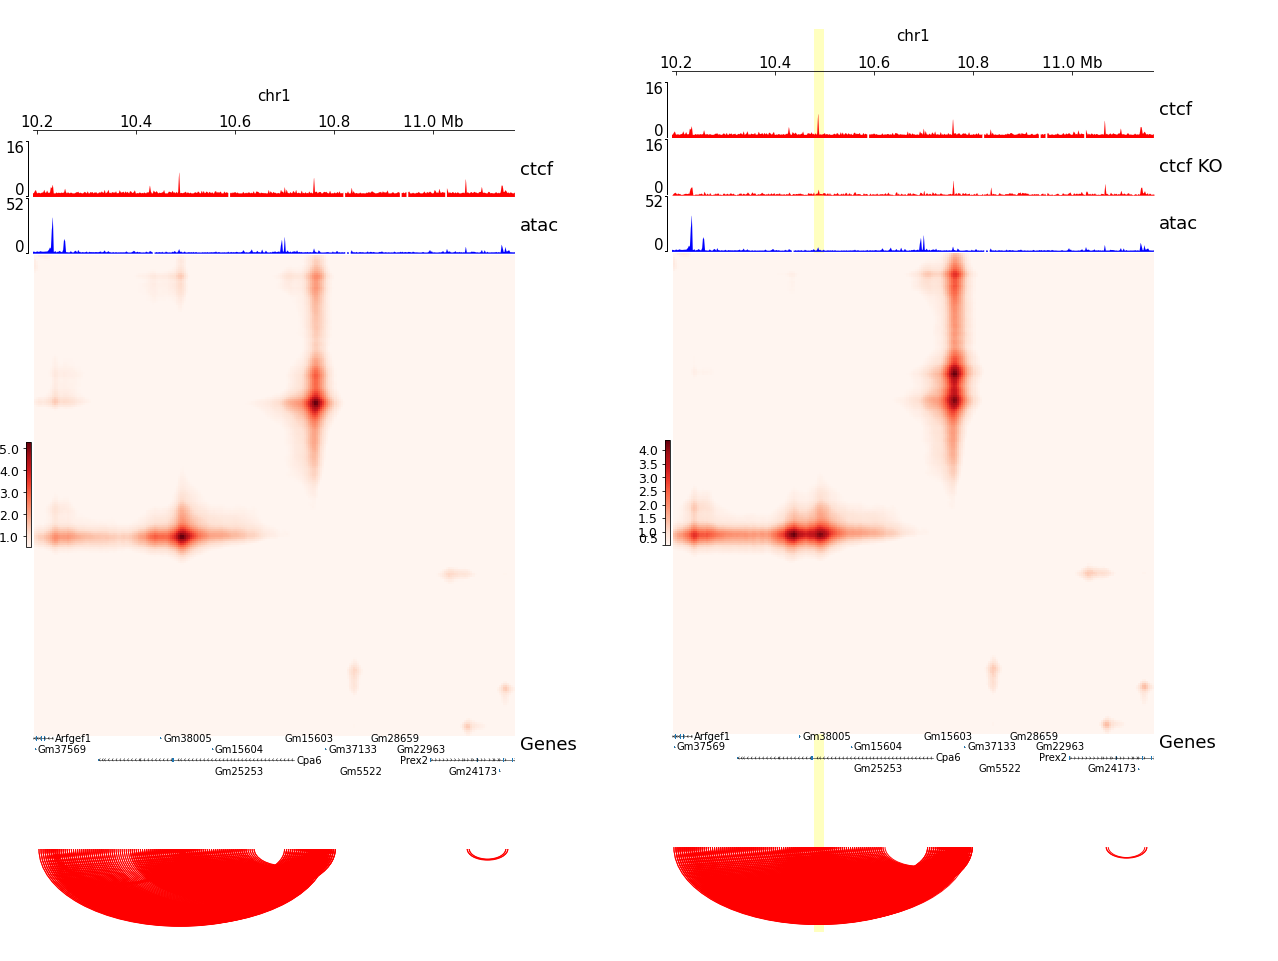

In [13]:
display_images(f'outputs/ctcf_ko_only_129_b6_5kb_{chrom}_{start}_ctcf_pred_tracks.png', 
               f'outputs/ctcf_ko_only_129_b6_5kb_{chrom}_{start}_ctcf_ko_tracks.png')

In [14]:
! python ../src/cshark/inference/perturb.py \
    --celltype 129_b6_5kb \
    --outname ctcf_ko_only \
    --chr $chrom \
    --start $start \
    --model /mnt/jinstore/JinLab02/dmp131/C.Shark/checkpoints/deeploop_b6_129_CTCF_ATAC_5kb.ckpt \
    --seq ../cshark_data/data/mm10/dna_sequence \
    --seq2 ../cshark_data/data/129/dna_sequence \
    --matrix-size 512 \
    --resolution 4096 \
    --region $region \
    --ko-start 10750000 \
    --ko-width 20000 \
    --ko ctcf \
    --ko-mode knockout \
    --min-val-pred 0.5 \
    --bigwigs ctcf=../cshark_data/data/mm10/129_b6_5kb/genomic_features/ctcf.bw \
              atac=../cshark_data/data/mm10/129_b6_5kb/genomic_features/atac.bw \
    --silent

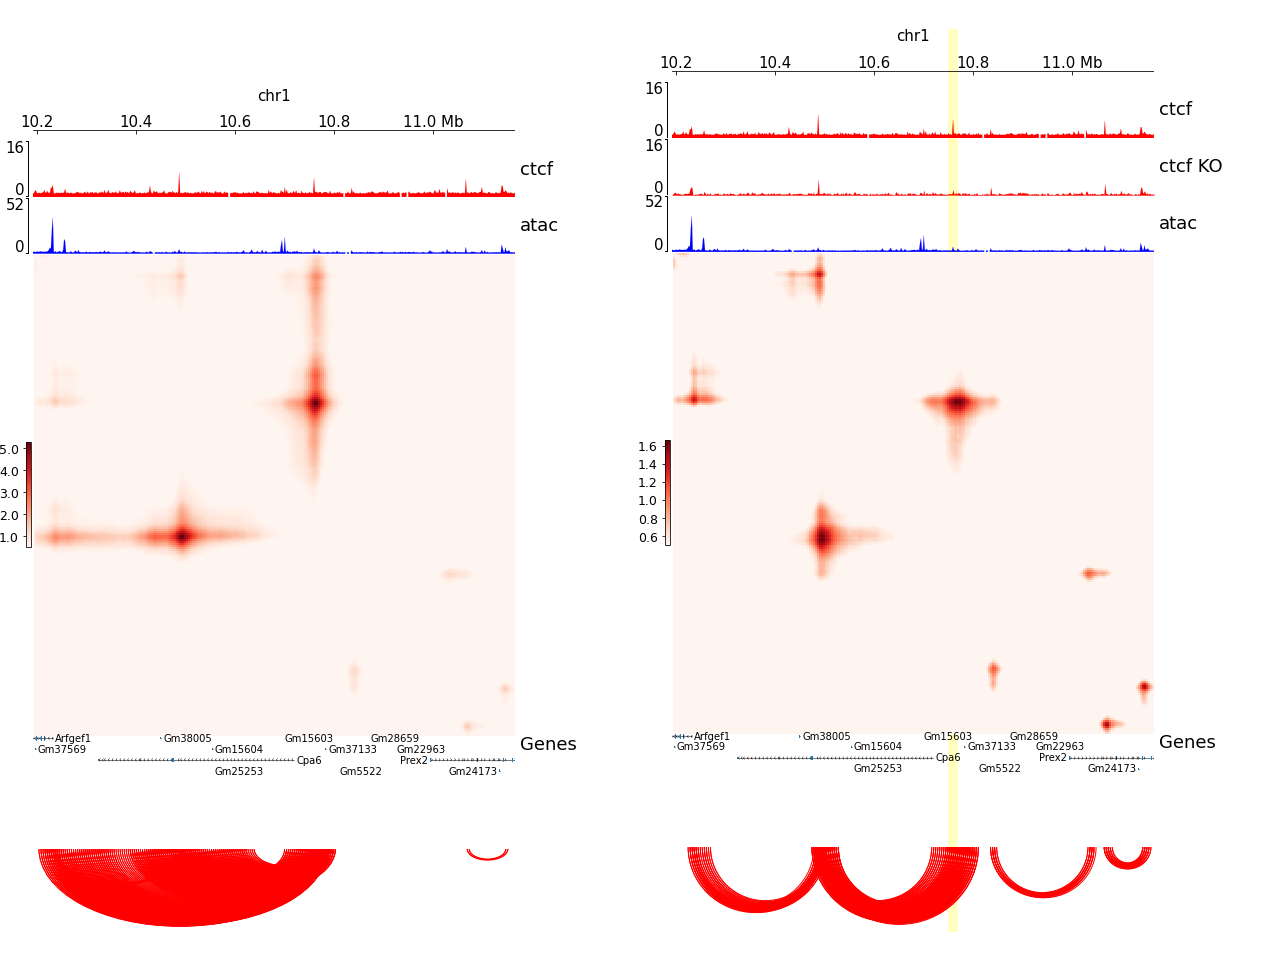

In [15]:
display_images(f'outputs/ctcf_ko_only_129_b6_5kb_{chrom}_{start}_ctcf_pred_tracks.png', 
               f'outputs/ctcf_ko_only_129_b6_5kb_{chrom}_{start}_ctcf_ko_tracks.png')

In [16]:
! python ../src/cshark/inference/perturb.py \
    --celltype 129_b6_5kb \
    --outname ctcf_ko_only \
    --chr $chrom \
    --start $start \
    --model /mnt/jinstore/JinLab02/dmp131/C.Shark/checkpoints/deeploop_b6_129_CTCF_ATAC_5kb.ckpt \
    --seq ../cshark_data/data/mm10/dna_sequence \
    --seq2 ../cshark_data/data/129/dna_sequence \
    --matrix-size 512 \
    --resolution 4096 \
    --region $region \
    --ko-start 11050000 \
    --ko-width 20000 \
    --ko ctcf \
    --ko-mode knockout \
    --min-val-pred 0.5 \
    --bigwigs ctcf=../cshark_data/data/mm10/129_b6_5kb/genomic_features/ctcf.bw \
              atac=../cshark_data/data/mm10/129_b6_5kb/genomic_features/atac.bw \
    --silent

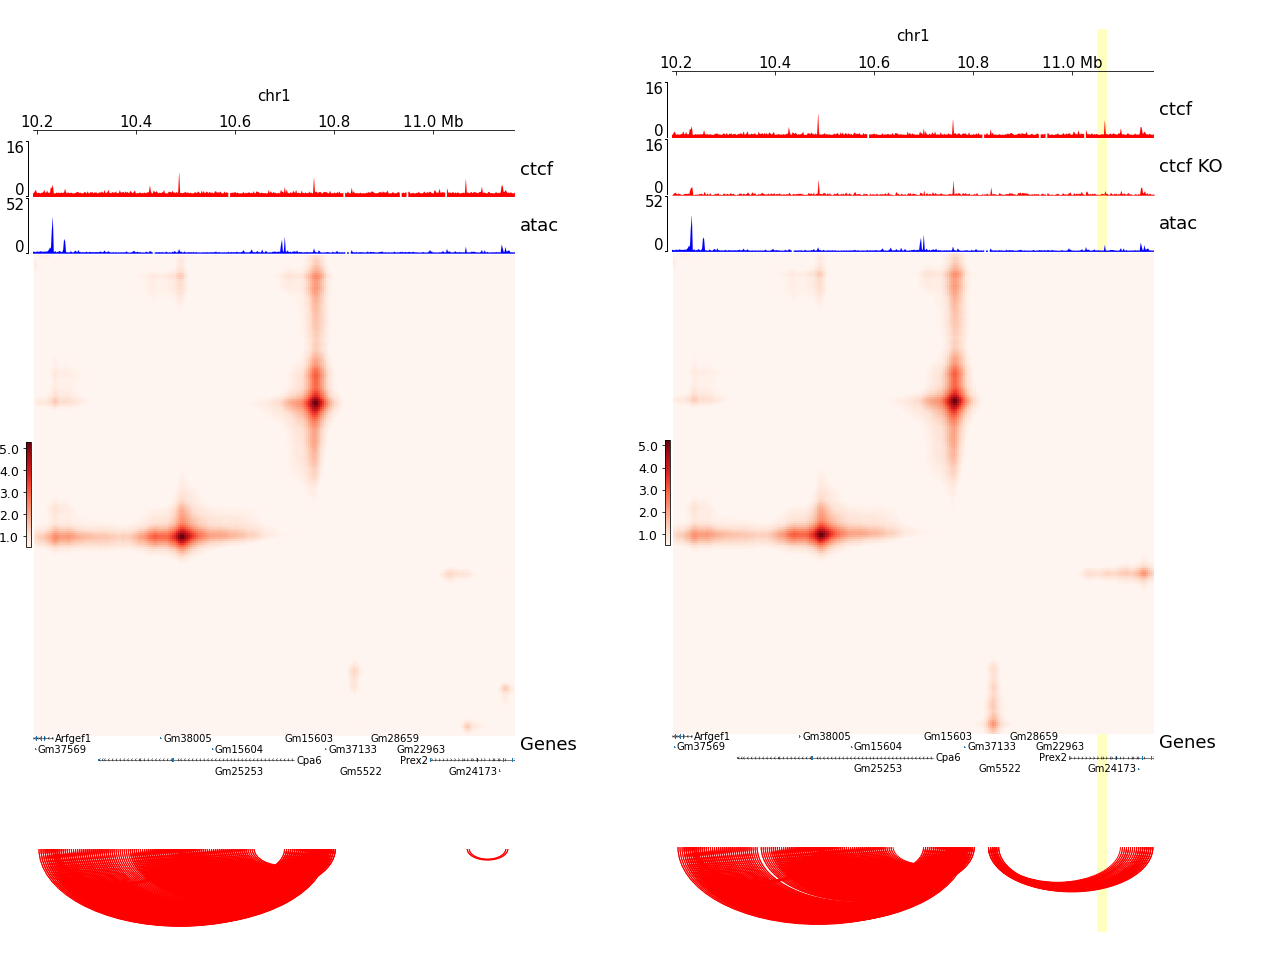

In [17]:
display_images(f'outputs/ctcf_ko_only_129_b6_5kb_{chrom}_{start}_ctcf_pred_tracks.png', 
               f'outputs/ctcf_ko_only_129_b6_5kb_{chrom}_{start}_ctcf_ko_tracks.png')